In [1]:
import os
import numpy as np
import pyccl as ccl
import healpy as hp
import matplotlib.pyplot as plt
import libconf
from scipy.integrate import simps
from astropy.io import fits

This notebook shows how to generate a CoLoRe simulation and analyse its outputs.

# 1 Generating inputs
Let's simulate a set of low-redshift tracers:
- A galaxy sample with median redshift $z\sim0.045$ including RSDs, lensing observables and density/velocity skewers.
- A set of 21cm intensity maps.
- A lensing convergence for a source plane at $z=0.1$.
- An ISW map for a source plane at $z=0.1$.
- A custom projected tracer with a kernel $W(z)=(0.1-z)$.

We start by defining the properties of the CoLoRe simulation box and the linear power spectrum to be used.

In [2]:
z_max = 0.15
n_grid = 256
csm = {'omega_M': 0.3,
       'omega_B': 0.3,
       'omega_L': 0.7,
       'h': 0.7,
       'w': -1.0,
       'ns': 0.96,
       'sigma_8': 0.8}
dirname_out = 'output'
os.system(f'mkdir -p {dirname_out}');

cosmo = ccl.Cosmology(Omega_c=csm['omega_M']-csm['omega_B'],
                      Omega_b=csm['omega_B'],
                      h=csm['h'],
                      sigma8=csm['sigma_8'],
                      n_s=csm['ns'],
                      transfer_function='eisenstein_hu')
k_h = np.geomspace(1E-4, 100, 1024)
pk_h = ccl.linear_matter_power(cosmo, k_h*cosmo['h'], 1.)*cosmo['h']**3
np.savetxt(f'{dirname_out}/pk.txt', np.transpose([k_h, pk_h]))

Let's generate the inputs needed for the galaxy sample

0.04513716654216523


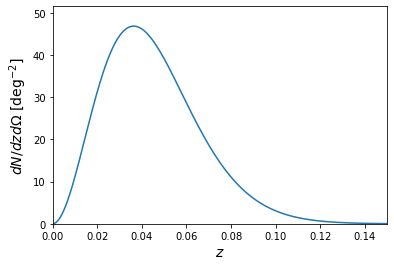

In [3]:
# Redshift distribution
ngals = 1E5
ndens = ngals / (4*np.pi*(180/np.pi)**2)
zs = np.linspace(0, 0.2, 1024)
nz = zs**2*np.exp(-(zs/0.03)**1.5)
nz *= ndens / simps(nz, x=zs)

# Linear bias
bz = (1+zs)

np.savetxt(f'{dirname_out}/dndz.txt', np.transpose([zs, nz]))
np.savetxt(f'{dirname_out}/bias.txt', np.transpose([zs, bz]))
plt.plot(zs, nz)
plt.ylim([0, np.amax(nz)*1.1])
plt.xlim([0, z_max])
plt.xlabel(r'$z$', fontsize=14)
plt.ylabel(r'$dN/dzd\Omega\,\,[{\rm deg}^{-2}]$', fontsize=14)
print(np.average(zs, weights=nz))

Now let's generate the input needed for the custom tracer.

Text(0, 0.5, '$W(z)$')

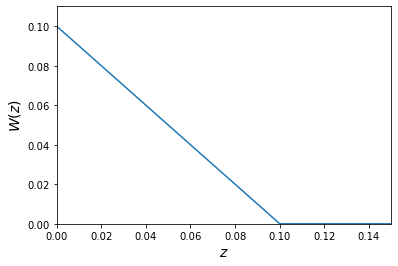

In [4]:
wz = (0.1-zs)
wz[zs > 0.1] = 0
np.savetxt(f'{dirname_out}/wz.txt', np.transpose([zs, wz]))

plt.plot(zs, wz)
plt.xlim([0, z_max])
plt.ylim([0, np.amax(wz)*1.1])
plt.xlabel(r'$z$', fontsize=14)
plt.ylabel(r'$W(z)$', fontsize=14)

Almost there. Now generate inputs needed for the intensity mapping observations.

In [5]:
# Constant background temperature T_HI = 0.05 mK
tz = 0.05 * np.ones_like(zs)

nu_ref = 1420.
nu0 = nu_ref / (1+0.14)
nu1 = nu_ref / (1+0.04)
n_nu = 5
nu_arr = np.linspace(nu0, nu1, n_nu+1)

np.savetxt(f'{dirname_out}/tz.txt', np.transpose([zs, tz]))
np.savetxt(f'{dirname_out}/nuTable.txt', np.transpose([nu_arr[:-1], nu_arr[1:]]))

Finally, pick a source plane for the ISW and convergence maps

In [6]:
z_source = 0.1

Before we can run CoLoRe, we need to create the config file. We will use 1st-order LPT as a structure formation model.

In [7]:
config = {}
config['global'] = {'prefix_out': dirname_out + '/colore',
                    'output_format': 'FITS',
                    'output_density': True,
                    'pk_filename': f'{dirname_out}/pk.txt',
                    'z_min': 0.0001,
                    'z_max': z_max,
                    'seed': 1000,
                    'write_pred': False,
                    'just_write_pred': False}
config['field_par'] = {'r_smooth': 1.,
                       'smooth_potential': True,
                       'n_grid': n_grid,
                       'dens_type': 1,
                       'lpt_buffer_fraction': 0.6,
                       'lpt_interp_type': 1,
                       'output_lpt': 0}
config['cosmo_par'] = csm
# Note: if you need more than one sample of galaxies/intensity maps/custom tracers etc.
# just add `srcs2` `imap2` etc.
config['custom1'] = {'kz_filename': f'{dirname_out}/wz.txt',
                     'bias_filename': f'{dirname_out}/bias.txt',
                     'nside': 64}
config['srcs1'] = {'nz_filename': f'{dirname_out}/dndz.txt',
                   'bias_filename': f'{dirname_out}/bias.txt',
                   'include_lensing': True,
                   'store_skewers': True}
config['imap1'] = {'tbak_filename': f'{dirname_out}/tz.txt',
                   'bias_filename': f'{dirname_out}/bias.txt',
                   'freq_list': f'{dirname_out}/nuTable.txt',
                   'freq_rest': 1420.0,
                   'nside': 64}
config['kappa'] = {'z_out': [z_source],
                   'nside': 64}
config['isw'] = {'z_out': [z_source],
                 'nside': 64}
with open(f'{dirname_out}/params.cfg', 'w') as configfile:
    libconf.dump(config, configfile)

# 2 Run CoLoRe
Now just run the code

In [3]:
os.system(f'LD_LIBRARY_PATH=/astro/u/anze/local/lib/ ./CoLoRe {dirname_out}/params.cfg > {dirname_out}/log.txt')
f = open(f'{dirname_out}/log.txt', 'r')
print(f.read())
f.close()

MPI task 0, OMP thread count starts at 0
 MPIThreadsOK = 1

|-------------------------------------------------|
|                      CoLoRe                     |
|-------------------------------------------------|

The cosmological model is:
 O_M=0.300 O_L=0.700 O_K=0.000
 O_B=0.300 w=-1.000 h=0.700
 Flat universe, standard cosmological constant

 Time of equality: a_eq=0.75416
 Particle horizon: chi_H(0)=9.908E+03 Mpc/h
 Present growth factor: D_0=0.779

Reading P_k from file: output/pk.txt
  Original sigma8=0.799990
  Sigma_Gauss should be 0.875326
Node 0 will allocate 0.597 GB [0.190 GB (Gaussian), 0.302 GB (1LPT), 0.102 GB (srcs), 0.002 GB (imap), 0.375 MB (kappa), 0.375 MB (isw), 0.375 MB (custom)]

Run parameters: 
  0.000 < z < 0.150
  0.300 < r/(Mpc/h) < 434.105
  L_box = 874.993 Mpc/h, N_grid = 256 
  Scales resolved: 7.181E-03 < k < 9.156E-01 h/Mpc
  Fourier-space resolution: dk = 7.181E-03 h/Mpc
  Real-space resolution: dx = 3.418E+00 Mpc/h
  Density field pre-smoothed on 

/astro/u/anze/local/lib/# 3 Inspect output
Let's now look at the output

## 3.1 Custom tracer
CoLoRe produces healpix maps for each custom projected tracer:

/cvmfs/astro.sdcc.bnl.gov/SL73/packages/bacon/latest/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/cvmfs/astro.sdcc.bnl.gov/SL73/packages/bacon/latest/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 64
  warnings.warn("NSIDE = {0:d}".format(nside))
/cvmfs/astro.sdcc.bnl.gov/SL73/packages/bacon/latest/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/cvmfs/astro.sdcc.bnl.gov/SL73/packages/bacon/latest/lib/python3.8/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in h

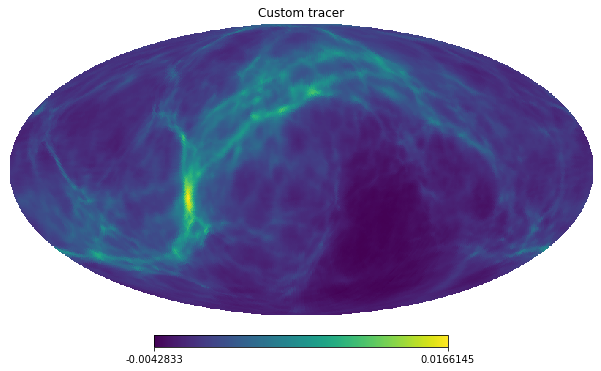

In [9]:
m = hp.read_map(f"{dirname_out}/colore_custom_s1.fits")
hp.mollview(m, title='Custom tracer')

## 3.2 Source catalogs
Galaxy samples are stored as FITS tables. Below we read this catalog, plot its redshift distribution, and maps of the galaxy overdensity, mean redshift distortions, and mean galaxy ellipticities.

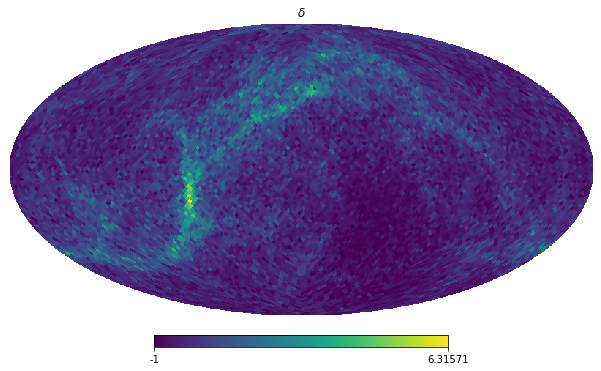

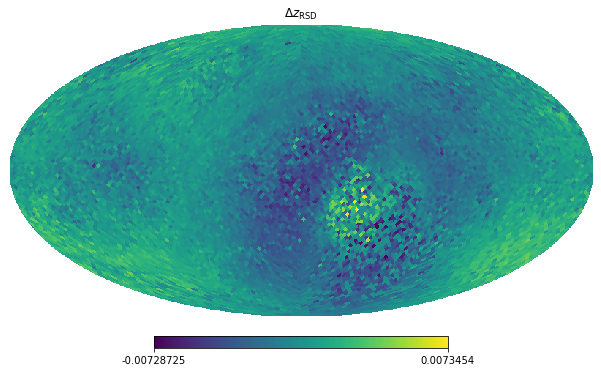

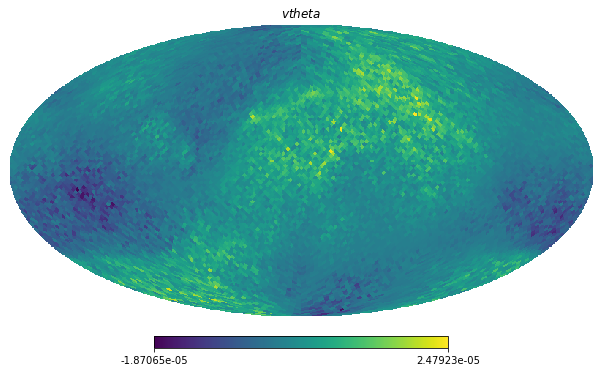

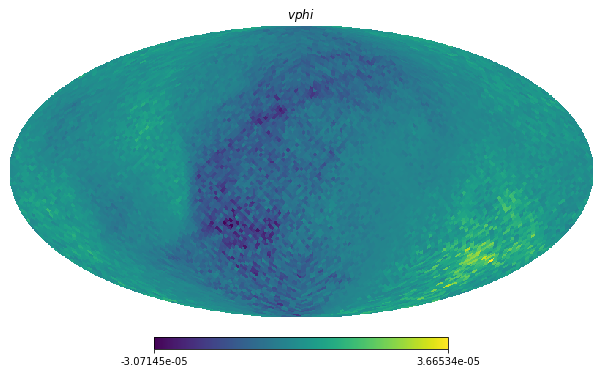

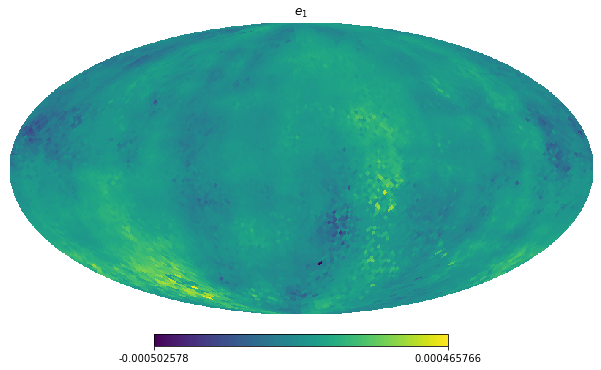

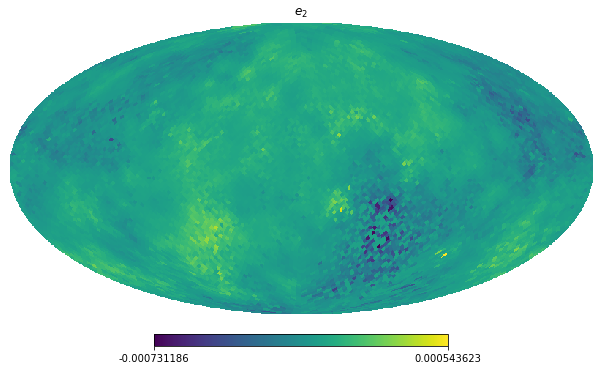

In [10]:
cat = fits.open(f"{dirname_out}/colore_srcs_s1_0.fits")[1].data
nside = 32
npix = hp.nside2npix(nside)
ipix = hp.ang2pix(nside, cat['RA'], cat['DEC'], lonlat=True)
ncount = np.bincount(ipix, minlength=npix)
goodpix = ncount > 0
nmean = np.mean(ncount)
delta = ncount/nmean-1
dzrsd = np.bincount(ipix, minlength=npix, weights=cat['DZ_RSD'])
vtheta = np.bincount(ipix, minlength=npix, weights=cat['VTHETA'])
vphi = np.bincount(ipix, minlength=npix, weights=cat['VPHI'])
dzrsd[goodpix] = dzrsd[goodpix] / ncount[goodpix]
e1 = np.bincount(ipix, minlength=npix, weights=cat['E1'])
e1[goodpix] = e1[goodpix] / ncount[goodpix]
e2 = np.bincount(ipix, minlength=npix, weights=cat['KAPPA'])
e2[goodpix] = e2[goodpix] / ncount[goodpix]
hp.mollview(delta, title=r'$\delta$')
hp.mollview(dzrsd, title=r'$\Delta z_{\rm RSD}$')
hp.mollview(vtheta, title=r'$vtheta$')
hp.mollview(vphi, title=r'$vphi$')
hp.mollview(e1, title='$e_1$')
hp.mollview(e2, title='$e_2$')

In [11]:
cat

FITS_rec([(0, 135.14798 , -72.023506, 0.14752357,  0.00420645,  9.1869111e-08,  6.9041323e-07,  6.3695380e-04,  2.0482158e-04, -5.5567569e-05,  0.00997258,  0.04110185),
          (0, 189.13899 , -74.79645 , 0.14293315, -0.00085942,  3.5034478e-07,  8.1963776e-07, -8.5430373e-05,  3.1329642e-04, -1.7480239e-04,  0.04010854,  0.02486622),
          (0, 255.18294 , -77.3037  , 0.13650647,  0.00199598,  6.7545272e-07,  1.1957115e-06,  5.8054029e-05, -3.0786011e-04, -8.2123920e-04,  0.03487576, -0.02573383),
          ...,
          (0,  21.777729,  79.76989 , 0.13463575, -0.0017074 ,  1.8299168e-06, -1.1566977e-06, -4.7826930e-04, -4.0466024e-05,  2.6472006e-04, -0.01369716, -0.00172807),
          (0,  98.69248 ,  77.87262 , 0.13808511, -0.00046557, -1.2522990e-07, -1.8932460e-06, -5.6265696e-04, -6.4774256e-05,  7.6205668e-04,  0.00199528, -0.00651289),
          (0, 146.01144 ,  79.69646 , 0.14366393, -0.00198077, -3.0381312e-07,  1.2278358e-06, -2.0604710e-04,  1.8634219e-04,  8.23361

## 3.3 Density/velocity skewers
The source catalogs are also endowed with "skewers" containing the density and radial velocity along galaxy lines of sight.

In [12]:
d_skw = fits.open('output/colore_srcs_s1_0.fits')[2].data
v_skw = fits.open('output/colore_srcs_s1_0.fits')[3].data
bkg = fits.open('output/colore_srcs_s1_0.fits')[4].data
r = bkg['R']

OSError: Header missing END card.

In [13]:
plt.figure()
plt.plot(r, d_skw[0])
plt.plot(r, d_skw[31])
plt.plot(r, 0*r, 'k--', lw=1)
plt.xlim([0, r[-1]])
plt.xlabel(r'$\chi\,\,[{\rm Mpc}/h]$', fontsize=14)
plt.ylabel(r'$\delta$', fontsize=14)

plt.figure()
plt.plot(r, v_skw[0])
plt.plot(r, v_skw[31])
plt.plot(r, 0*r, 'k--', lw=1)
plt.xlim([0, r[-1]])
plt.xlabel(r'$\chi\,\,[{\rm Mpc}/h]$', fontsize=14)
plt.ylabel(r'$v_r/c$', fontsize=14);

NameError: name 'r' is not defined

<Figure size 432x288 with 0 Axes>

## 3.4 Intensity maps
Intensity maps are stored as HEALPix maps.

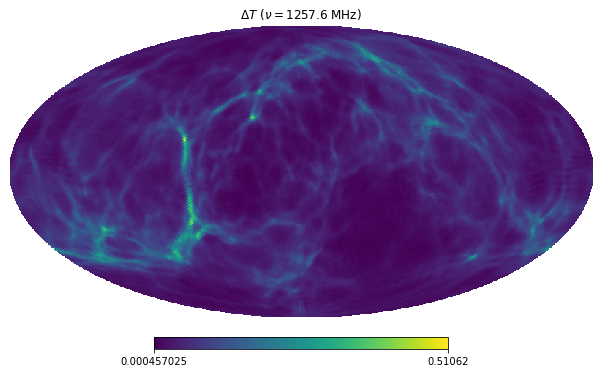

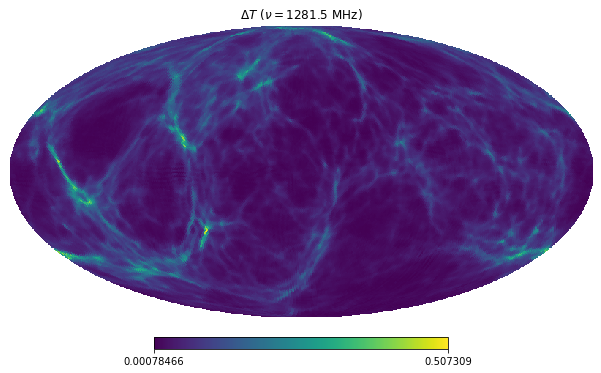

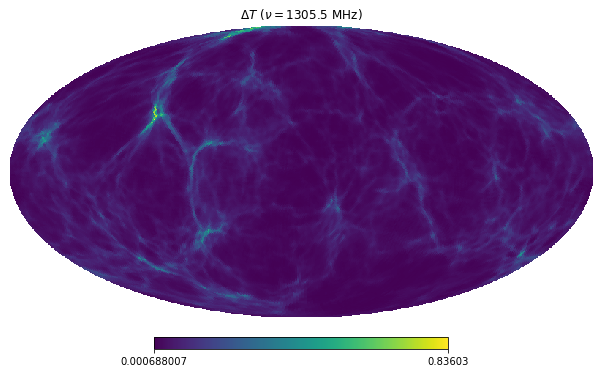

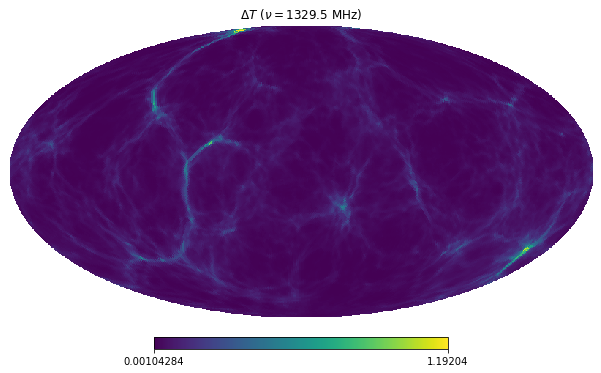

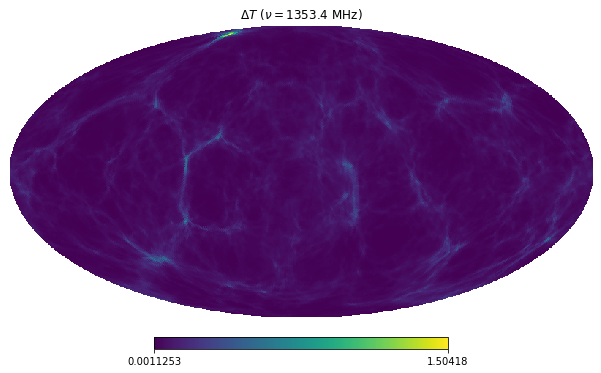

In [14]:
for i in range(5):
    nu = 0.5*(nu_arr[i] + nu_arr[i+1])
    m = hp.read_map(f'{dirname_out}/colore_imap_s1_nu00{i}.fits')
    hp.mollview(m, title='$\\Delta T\\,\\,(\\nu = %.1lf\\,\\,{\\rm MHz})$' % nu)

## 3.5 Convergence and ISW maps
Again, stored as HEALPix maps

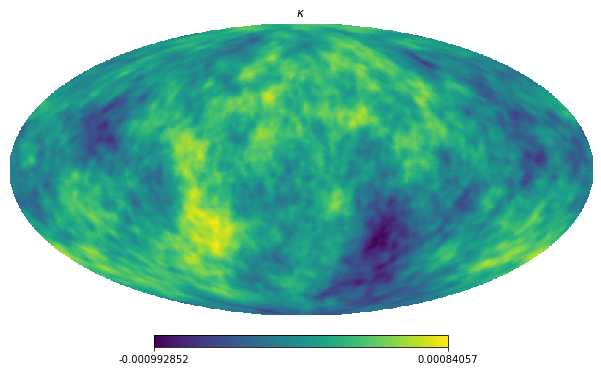

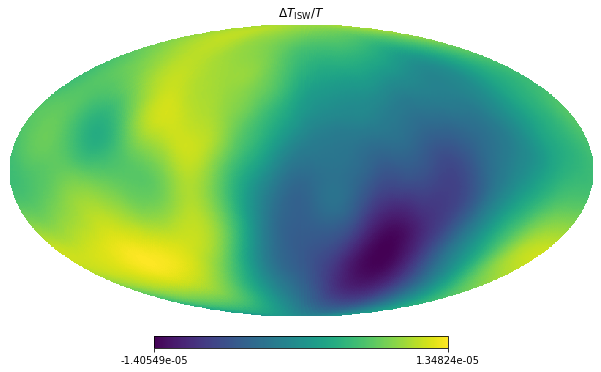

In [15]:
m_k = hp.read_map('output/colore_kappa_z000.fits')
m_i = hp.read_map('output/colore_isw_z000.fits')
hp.mollview(m_k, title=r'$\kappa$')
hp.mollview(m_i, title=r'$\Delta T_{\rm ISW}/T$')

## 3.6 Cartesian density grids
CoLoRe can also optionally output the matter overdensity boxes used to generate the simulation.

Ngrid = 256
Lbox = 874.993 Mpc/h


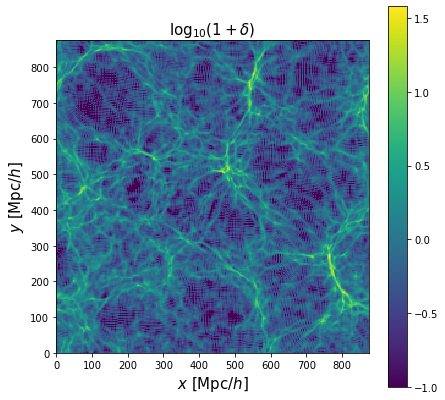

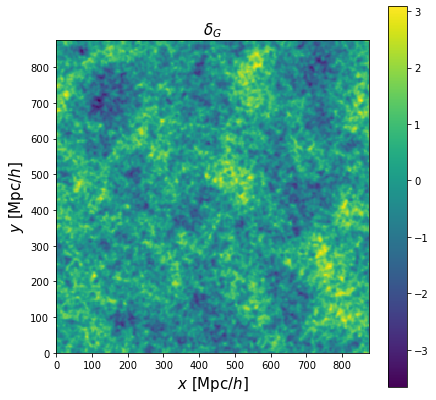

In [16]:
def read_grid(prefix):
    f = open(prefix+"_0.dat", "rb")
    nfiles, size_float = np.fromfile(f, dtype=np.int32, count=2)
    lbox = np.fromfile(f, dtype=np.float64, count=1)[0]
    ngrid = np.fromfile(f, dtype=np.int32, count=1)[0]
    f.close()

    if size_float == 4:
        f_type = np.float32
    else:
        f_type = np.float64

    grid_out = np.zeros([ngrid, ngrid, ngrid])
    for ifil in np.arange(nfiles):
        f = open(prefix+"_%d.dat" % ifil, "rb")
        nf, sz = np.fromfile(f, dtype=np.int32, count=2)
        _ = np.fromfile(f, dtype=np.float64, count=1)
        ng, nz_here, iz0_here = np.fromfile(f, dtype=np.int32, count=3)
        for iz in np.arange(nz_here):
            d = np.fromfile(f, dtype=f_type, count=ng*ng).reshape([ng, ng])
            grid_out[iz0_here+iz, :, :] = d
        f.close()

    return ngrid, lbox, np.array(grid_out)

ng, lb, dens = read_grid('output/colore_dens_lightcone')
_, _, densG = read_grid('output/colore_dens_gaussian')
print("Ngrid = %d" % ng)
print("Lbox = %.3lf Mpc/h" % lb)


plt.figure(figsize=(7, 7))
plt.title(r'$\log_{10}(1+\delta)$', fontsize=15)
plt.imshow(np.log10(1.001+dens[ng//2, :, :]),
           origin='lower',
           interpolation='nearest',
           vmin=-1, extent=[0, lb, 0, lb])
plt.colorbar()
plt.xlabel(r'$x\,\,[{\rm Mpc}/h]$', fontsize=15)
plt.ylabel(r'$y\,\,[{\rm Mpc}/h]$', fontsize=15)

plt.figure(figsize=(7, 7))
plt.title(r'$\delta_G$', fontsize=15)
plt.imshow(densG[ng//2, :, :], origin='lower',
           interpolation='nearest',
           extent=[0, lb, 0, lb])
plt.colorbar()
plt.xlabel(r'$x\,\,[{\rm Mpc}/h]$', fontsize=15)
plt.ylabel(r'$y\,\,[{\rm Mpc}/h]$', fontsize=15);